In [1]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations, product
import seaborn as sns
import copy

import tensorflow as tf
import tensorflow_lattice as tfl
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from keras.optimizers import Adam, Nadam, RMSprop
from keras.models import clone_model
import keras_tuner as kt
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
from keras.losses import Poisson, Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

import xgboost as xgb
from scipy.stats import uniform, randint
from pygam import GammaGAM, GAM, s, f, l, te # s for spline, f for factor, l for linear, te for tensor product
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from interpret.glassbox import ExplainableBoostingRegressor

In [2]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
############################ 1. DATA PREPARATION ############################

#-------------------------- import data --------------------------
data = pd.read_csv("synthetic_low_var.csv")

In [4]:
#-------------------------- remove outliers --------------------------
log_claim = np.log(data['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_cleaned = data[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,0.855910,-0.977807,0.070514,0.247397,-0.844805,-0.633014,0.932805,269.727579
1,0.430379,-0.917687,-0.577348,0.805874,-0.996460,0.808088,-0.727145,0.592222,0.416902,0.949203,606.423722
2,0.205527,0.846601,-0.046190,-0.144766,-0.689890,0.004793,0.787168,-0.029304,-0.254262,-0.739165,6740.904922
3,0.089766,-0.187530,-0.835531,0.021611,-0.366478,-0.798260,-0.363850,0.669637,-0.150974,0.020263,6749.592779
4,-0.152690,0.888564,-0.524681,0.166400,0.303690,0.055164,0.158018,0.046901,-0.468522,-0.772319,79.024055
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.496349,0.336766,0.766494,-0.723110,0.451842,-0.547824,0.165682,-0.515032,0.372611,-0.262674,30.561326
19996,-0.403467,0.989823,-0.239838,0.690306,0.015041,0.168038,-0.808643,-0.903895,-0.433667,-0.389854,105.129106
19997,-0.107088,0.176448,-0.661992,0.568246,0.620266,0.669292,-0.267906,0.006409,0.871063,-0.570751,1101.252426
19998,-0.279747,-0.150770,-0.472139,0.238510,0.102065,-0.832383,0.539168,0.073274,0.110462,-0.408447,634.928937


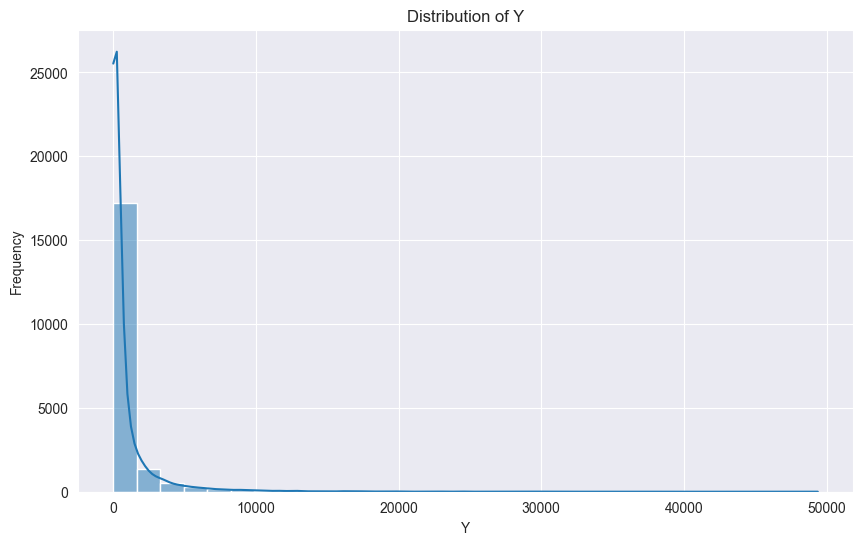

In [5]:
#-------------------------- distribution of response --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(dt_cleaned['Y'], bins = 30, kde = True) # draw the chart
plt.title('Distribution of Y')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

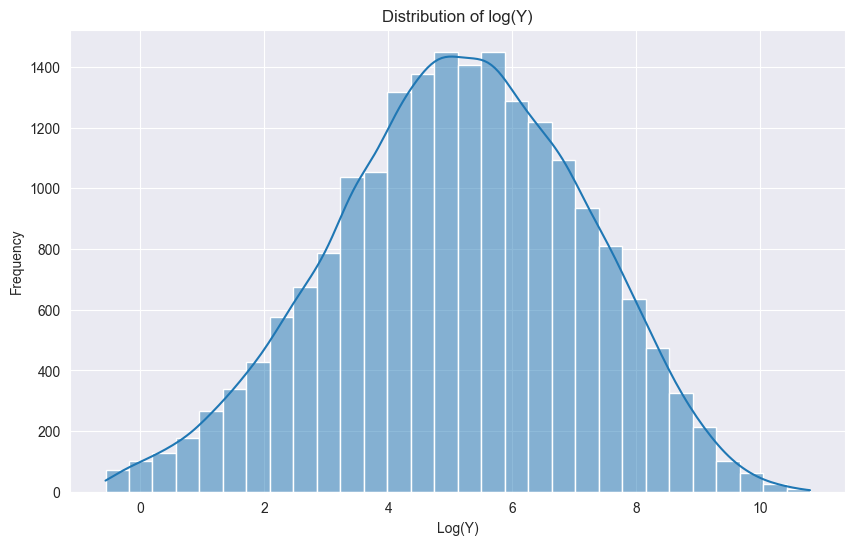

In [6]:
#-------------------------- distribution of log(response) --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y)')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [7]:
#-------------------------- column lists --------------------------
target_var = "Y" # target feature
all_vars = list(dt_cleaned.columns)
imp_vars = [f"X{i}" for i in range(1,7)] # variables used for predictions
cat_vars = [] # categorical features

In [8]:
#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_cleaned[imp_vars], dt_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [9]:
# -------------------------- create custom functions--------------------------
# gamma log likelihood
def gamma_nll(y_true, y_pred):
    y_pred = keras.ops.clip(y_pred, 1e-7, 1e30)
    loss = keras.ops.mean(y_true/y_pred - keras.ops.log(y_true/y_pred))
    return loss

In [10]:
############################ NEURAL NETS ############################

#-------------------------- define the neural network architecture--------------------------
def build_NN(hp):

    # tuning hyperparameters
    num_layers = hp.Int('num_dense_layers', 3, 10, step = 1) # number of hidden layers
    num_neurons = hp.Int(f'num_neurons', 20, 100, step = 10) # number of neurons per hidden layer
    dropout_rate = hp.Float(f'dropout_rate', min_value = 0, max_value = 0.3, step = 0.1) # dropout rate
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'softplus', 'swish'])

    # architecture
    input_layer = Input((X_train.shape[1],))
    x = input_layer
    for i in range(num_layers):
        x = Dense(units = num_neurons, activation = activation)(x)
        x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation = "exponential")(x)

    # model
    model = Model(inputs = input_layer, outputs = output_layer)
    
    # build model
    model.compile(optimizer = RMSprop(learning_rate = lr),
            loss = gamma_nll,
            metrics = [gamma_nll, RootMeanSquaredError(), MeanAbsoluteError()])
    
    return model

In [11]:
# -------------------------- tune and fit the model --------------------------
# tuner
tuner_NN = kt.BayesianOptimization(
    build_NN,
    objective = 'val_loss',
    max_trials = 20,
    directory = "hyperparameter_synthetic_NN",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True, verbose = 0)

# search for the best model
tuner_NN.search(X_train, y_train,
        epochs = 5_000,
        batch_size = 1_000,
        validation_data = (X_val, y_val),
        callbacks = [es])

# get the best model
model_NN = tuner_NN.get_best_models()[0]
tuner_NN.results_summary(1)

Trial 20 Complete [00h 14m 09s]
val_loss: 1.6794204711914062

Best val_loss So Far: 1.6768860816955566
Total elapsed time: 00h 28m 11s
Results summary
Results in hyperparameter_synthetic_NN/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 18 summary
Hyperparameters:
num_dense_layers: 3
num_neurons: 70
dropout_rate: 0.0
learning_rate: 0.00018950973173279142
activation: swish
Score: 1.6768860816955566


/Users/tupho/miniconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
#-------------------------- evaluate predictive performance --------------------------
_, nn_nll, nn_rmse, nn_mae = model_NN.evaluate(X_test, y_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - gamma_nll: 1.6707 - loss: 1.6707 - mean_absolute_error: 786.0472 - root_mean_squared_error: 2087.9626


In [13]:
############################ GLM ############################
# -------------------------- data prep --------------------------
# add intercept terms
train = sm.add_constant(X_main)
test = sm.add_constant(X_test)

# create interaction columns
train['X3_X4'] = train['X3'] * train['X4']
train['X5_X6'] = train['X5'] * train['X6']
test['X3_X4'] = test['X3'] * test['X4']
test['X5_X6'] = test['X5'] * test['X6']

# -------------------------- fit a GLM with Gaussian distribution --------------------------
model = sm.GLM(y_main, train, family = sm.families.Gamma(sm.families.links.log()))
model_glm = model.fit()

# get model summary
print(model_glm.summary())

/Users/tupho/miniconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                15860
Model:                            GLM   Df Residuals:                    15851
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                          4.3542
Method:                          IRLS   Log-Likelihood:            -1.1669e+05
Date:                Wed, 02 Oct 2024   Deviance:                       44180.
Time:                        17:24:12   Pearson chi2:                 6.90e+04
No. Iterations:                    28   Pseudo R-squ. (CS):             0.1254
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4825      0.017    391.052      0.0

In [14]:
# -------------------------- create custom functions--------------------------
# gamma log likelihood - numpy version
def gamma_nll_np(y_true, y_pred):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.clip(y_pred, 1e-7, 1e30)
    loss = np.mean(y_true/y_pred - np.log(y_true/y_pred))
    return loss

In [15]:
# -------------------------- evaluate model performance --------------------------
glm_pred = model_glm.predict(test)
glm_nll = gamma_nll_np(y_test, glm_pred)
glm_rmse = np.sqrt(mse(y_test, glm_pred))
glm_mae = mae(y_test, glm_pred)
print(f"Gamma negative loglikehood: {glm_nll}")
print(f"RMSE: {glm_rmse}")
print(f"MAE: {glm_mae}")

Gamma negative loglikehood: 2.3953957515374356
RMSE: 2239.1335357604644
MAE: 1042.0400431332632


In [16]:
############################ GBM ############################
# -------------------------- hyperparamter tuning --------------------------
# initialize XGBoost
xgb_reg = xgb.XGBRegressor(
    objective = 'reg:gamma',
    seed = 2024,
    subsample = 0.8,
    verbosity = 0  # Suppress warnings
)

# tuning hyperparamters
param_dist = {
    'eta': uniform(0.01, 0.2), # learning rate (0.01 to 0.21)
    'max_depth': randint(3, 11), # maximum tree depth (3 to 10)
    'n_estimators': randint(100, 501)  # number of trees (100 to 500)
}

# set up random search
random_search_gbm = RandomizedSearchCV(
    estimator = xgb_reg,
    param_distributions = param_dist,
    n_iter = 50,  # Number of parameter settings sampled
    scoring = "neg_mean_gamma_deviance",
    cv = 5,
    verbose = 1,
    random_state = 2024,
    n_jobs = -1 # using all processors for parallel processing
)

# perform the search
random_search_gbm.fit(X_main, y_main)

# -------------------------- Best Parameters and Score --------------------------
print("Best Hyperparameters:", random_search_gbm.best_params_)
print("Best Gamma Log Likehood:", random_search_gbm.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tupho/miniconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'eta': 0.18480796007486588, 'max_depth': 3, 'n_estimators': 344}
Best Gamma Log Likehood: -1.3711715171733607


In [17]:
# -------------------------- evaluation --------------------------
model_gbm = random_search_gbm.best_estimator_ # get the best model
gbm_pred = model_gbm.predict(X_test) # get the prediction

# get metrics on test data
gbm_nll = gamma_nll_np(y_test, gbm_pred)
gbm_rmse = np.sqrt(mse(y_test, gbm_pred))
gbm_mae = mae(y_test, gbm_pred)
print(f"Gamma negative loglikehood: {gbm_nll}")
print(f"RMSE: {gbm_rmse}")
print(f"MAE: {gbm_mae}")

Gamma negative loglikehood: 1.6424533534900139
RMSE: 1833.1595180441448
MAE: 690.6939161473122


In [18]:
############################ GAM ############################

# -------------------------- define the GAM model --------------------------
model_gam = GammaGAM(
    s(0) +          # spline for X1
    s(1) +          # spline for X2
    s(2, constraints = 'monotonic_dec') +  # negative monotonicity for X3
    s(3) +          # spline for X4
    s(4) +          # spline for X5
    s(5) +          # spline for X6
    te(2, 3) +  # interaction term between X3 and X4
    te(4, 5)  # interaction term between X5 and X6
)

# -------------------------- define hyperparameter for tuning --------------------------
# Define the hyperparameter grid
lam_values = np.linspace(0.1, 5, 5)
n_splines_values = [10, 15, 20, 25]

# -------------------------- # Perform gridsearch --------------------------
model_gam.gridsearch(np.asarray(X_main), np.asarray(y_main), lam = lam_values, n_splines = n_splines_values)

  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  5% (1 of 20) |#                        | Elapsed Time: 0:00:10 ETA:   0:03:20
 10% (2 of 20) |##                       | Elapsed Time: 0:00:32 ETA:   0:04:50
 15% (3 of 20) |###                      | Elapsed Time: 0:01:16 ETA:   0:07:14


KeyboardInterrupt: 

In [60]:
# -------------------------- evaluation --------------------------
gam_pred = model_gam.predict(X_test) # get the prediction

# get metrics on test data
gam_nll = gamma_nll_np(y_test, gam_pred)
gam_rmse = np.sqrt(mse(y_test, gam_pred))
gam_mae = mae(y_test, gam_pred)
print(f"Gamma negative loglikehood: {gam_nll}")
print(f"RMSE: {gam_rmse}")
print(f"MAE: {gam_mae}")

Gamma negative loglikehood: 1.5500582239181282
RMSE: 1736.3857319122226
MAE: 667.7640775101929


In [61]:
############################ EXPLAINABLE BOOSTING MACHINE ############################

# -------------------------- define the model --------------------------
model_ebm = ExplainableBoostingRegressor(
    interactions=[(2, 3), (4, 5)],  # (X3, X4) and (X5, X6)
    objective = "gamma_deviance",
    monotone_constraints = [0,0,-1,0,0,0],
    n_jobs = -1,
    random_state = 2024
)

# Fit the model
model_ebm.fit(X_main, y_main)

ExplainableBoostingRegressor(interactions=[(2, 3), (4, 5)],
                             monotone_constraints=[0, 0, -1, 0, 0, 0],
                             n_jobs=-1, objective='gamma_deviance',
                             random_state=2024)

In [62]:
# -------------------------- evaluation --------------------------
ebm_pred = model_ebm.predict(X_test) # get the prediction

# get metrics on test data
ebm_nll = gamma_nll_np(y_test, ebm_pred)
ebm_rmse = np.sqrt(mse(y_test, ebm_pred))
ebm_mae = mae(y_test, ebm_pred)
print(f"Gamma negative loglikehood: {ebm_nll}")
print(f"RMSE: {ebm_rmse}")
print(f"MAE: {ebm_mae}")

Gamma negative loglikehood: 1.6428907783386397
RMSE: 1825.9862831169817
MAE: 708.6440957379849


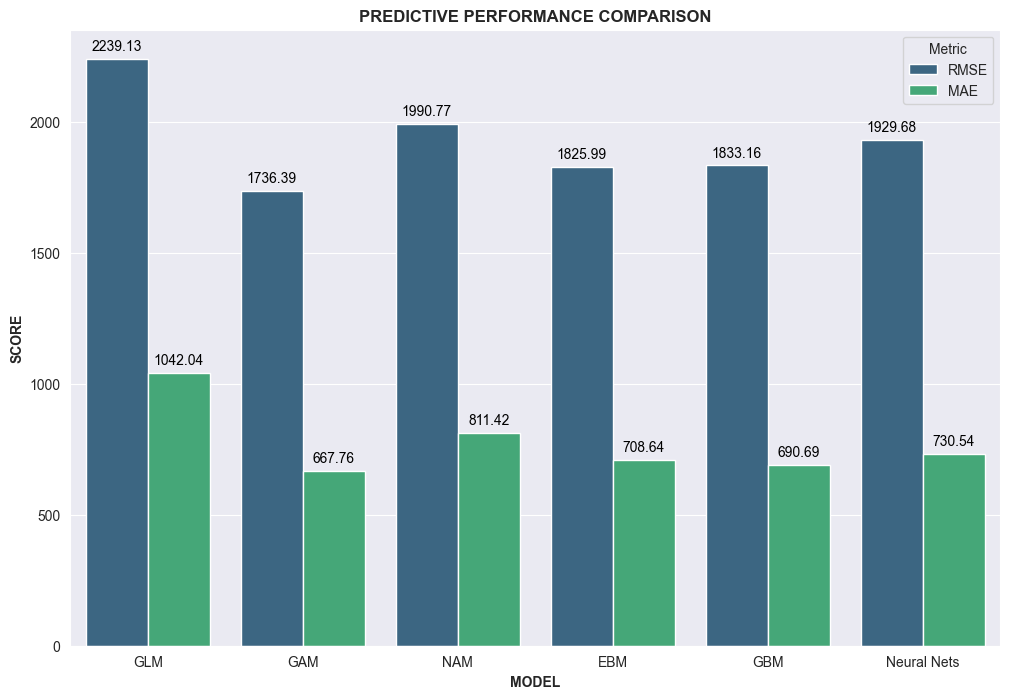

In [79]:
############################ COMPARISON ############################

# NAM performance
nam_nll = 1.8017
nam_rmse = 1990.77
nam_mae = 811.424

# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM', 'GLM',
              'GAM', 'GAM',
              'NAM', 'NAM',
              'EBM', 'EBM',
              'GBM', 'GBM',
              'Neural Nets', 'Neural Nets'],
    'Metric': ['RMSE', 'MAE',
               'RMSE', 'MAE',
               'RMSE', 'MAE',
               'RMSE', 'MAE',
               'RMSE', 'MAE',
               'RMSE', 'MAE'],
    'Value': [glm_rmse, glm_mae,
              gam_rmse, gam_mae,
              nam_rmse, nam_mae,
              ebm_rmse, ebm_mae,
              gbm_rmse, gbm_mae,
              nn_rmse, nn_mae]
}
df_performance = pd.DataFrame(df_performance)

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (12, 8))
barplot = sns.barplot(x = 'Model', y = 'Value', hue = 'Metric', data = df_performance, palette = 'viridis')


'''AI: the code below is adapted from an answer given by ChatGPT. This is declared in the AI Appendix'''
# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.2f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 10, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON', fontsize = 12, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 10, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 10, fontweight = 'bold')
barplot.legend(title = 'Metric', fontsize = 10, title_fontsize = 10)

# size of x-label
barplot.tick_params(labelsize = 10)

# Show the plot
plt.show()

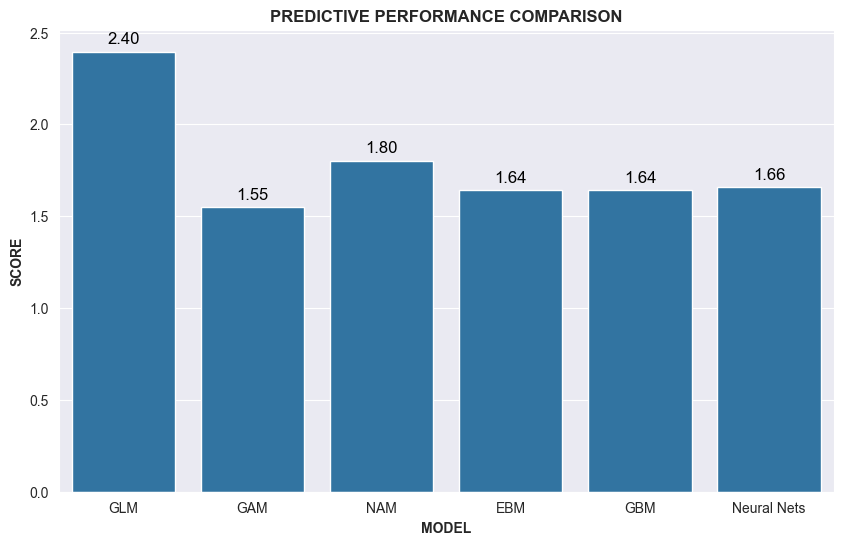

In [80]:
# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM',
              'GAM',
              'NAM',
              'EBM',
              'GBM',
              'Neural Nets'],
    'Gamma NLL': [glm_nll,
                gam_nll,
                nam_nll,
                ebm_nll,
                gbm_nll,
                nn_nll]
}
df_performance = pd.DataFrame(df_performance)

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Model', y = 'Gamma NLL', data = df_performance)


'''AI: the code below is adapted from an answer given by ChatGPT. This is declared in the AI Appendix'''
# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.2f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 12, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON', fontsize = 12, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 10, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 10, fontweight = 'bold')

# size of x-label
barplot.tick_params(labelsize = 10)

# Show the plot
plt.show()